> **Note:** This notebook is based on material from  
> _**Portfolio Optimization: Theory and Application**_  
> by **Daniel P. Palomar**.


# Pair Trading: Basics and Cointegration

## 1. Intuition of Pair Trading

Pair trading is a **market-neutral** strategy that exploits the relative mispricing between two historically related assets.

Core idea:

- Find two assets whose prices **move together** in the long run (same industry, same factor exposures, etc.).
- Construct a **spread** between them that is (ideally) **mean-reverting**.
- When the spread is “too high” relative to its typical behavior, you expect it to fall back → **short the spread**.
- When the spread is “too low”, you expect it to rise back → **long the spread**.

You are not trying to predict the market direction; instead you are betting on the **relationship** between the two assets.

---

## 2. Mathematical Setup

Let:

- $P_{1,t}$: price of asset 1 (e.g. PEP) at time $t$
- $P_{2,t}$: price of asset 2 (e.g. KO) at time $t$

Often we work with **log prices**:

$$
y_{1,t} = \log P_{1,t},
\quad
y_{2,t} = \log P_{2,t}.
$$

### 2.1 Linear relationship and hedge ratio

We postulate a linear long-run relationship:

$$
y_{1,t} \approx \mu + \gamma\, y_{2,t} + \varepsilon_t,
$$

where:

- $\mu$: intercept,
- $\gamma$: **hedge ratio** (how many units of asset 2 to hedge asset 1),
- $\varepsilon_t$: residual (spread).

We estimate $\mu$ and $\gamma$ using **ordinary least squares (OLS)** on historical data:

$$
y_{1,t} = \mu + \gamma\, y_{2,t} + \varepsilon_t, \quad t=1,\dots,T.
$$

### 2.2 Spread construction

With estimated parameters $\hat\mu, \hat\gamma$, define the **spread**:

$$
s_t = y_{1,t} - \hat\mu - \hat\gamma\, y_{2,t}.
$$

If the pair is good, $s_t$ should be approximately **stationary and mean-reverting** around 0 (or around a constant).

For a simple “un-normalized” pair portfolio:

- Long 1 unit of asset 1
- Short $\hat\gamma$ units of asset 2  

The (log) value of that portfolio is proportional to:

$$
\tilde{s}_t = y_{1,t} - \hat\gamma\, y_{2,t}.
$$

Sometimes we use a **normalized spread** so that the notional is 1 unit of capital:

$$
z_t = \frac{y_{1,t} - \hat\mu - \hat\gamma y_{2,t}}{1 + \hat\gamma}.
$$

This corresponds to weights:

$$
w_{1} = \frac{1}{1+\hat\gamma}, \quad
w_{2} = -\frac{\hat\gamma}{1+\hat\gamma},
$$

so the total absolute exposure is 1.

---

## 3. Trading Rules: Z-score Strategy

We want to detect when the spread is “unusually high or low”.

### 3.1 Rolling mean and standard deviation

Choose a **lookback window** (e.g. last 60 trading days). Compute:

$$
m_t = \text{rolling mean of } s_t,
\quad
\sigma_t = \text{rolling standard deviation of } s_t.
$$

Define the **z-score**:

$$
z_t = \frac{s_t - m_t}{\sigma_t}.
$$

This tells you how many standard deviations the current spread is away from its recent average.

### 3.2 Example threshold strategy

Let $z_t$ be the z-score of the spread.

- **Entry rules**:
  - If $z_t > z_{\text{entry}}$: spread is high  
    → short spread (short asset 1, long $\hat\gamma$ units of asset 2).
  - If $z_t < -z_{\text{entry}}$: spread is low  
    → long spread (long asset 1, short $\hat\gamma$ units of asset 2).

- **Exit rules**:
  - Close the position when $|z_t| < z_{\text{exit}}$ (e.g. when it reverts toward 0).

Typical choices:

- $z_{\text{entry}} \approx 1$ or $2$,
- $z_{\text{exit}} \approx 0$ or $0.5$.

This is a **contrarian strategy**: bet on mean-reversion of the spread.

---

## 4. Cointegration: Why It Matters

### 4.1 Stationarity vs nonstationarity

Many financial price series are **nonstationary** and behave roughly like random walks:

$$
P_{t} = P_{t-1} + \text{noise}.
$$

A **stationary** process has:

- constant mean,
- constant variance,
- autocovariance depending only on the lag, not on time.

Stationary series can revert to a mean; pure random walks do not.

### 4.2 Cointegration definition

Two nonstationary series $(y_{1,t})$ and $(y_{2,t})$, each integrated of order 1 (I(1)), are **cointegrated** if there exists a linear combination:

$$
u_t = y_{1,t} - \beta_0 - \beta_1 y_{2,t}
$$

that **is stationary** (I(0)).

Interpretation:

- Each series by itself may drift and wander.
- But a particular linear combination (the spread) is stable and mean-reverting.

This is exactly what we want in pair trading: the spread should be mean-reverting.

---

## 5. Basic Cointegration Tests

There are two common approaches:

1. **Engle–Granger two-step test** (for 2 series)


### 5.1 Engle–Granger Two-Step Test

Used for **two** time series.

**Step 1: Long-run regression**

Regress one series on the other (usually in levels):

$$
y_{1,t} = \beta_0 + \beta_1 y_{2,t} + \varepsilon_t.
$$

Estimate $\hat\beta_0, \hat\beta_1$, and obtain residuals:

$$
\hat\varepsilon_t = y_{1,t} - \hat\beta_0 - \hat\beta_1 y_{2,t}.
$$

**Step 2: Unit root test on residuals**

Apply a **unit root test** (e.g. augmented Dickey–Fuller, ADF) on $\hat\varepsilon_t$:

$$
\Delta \hat\varepsilon_t = \phi\, \hat\varepsilon_{t-1} + \sum_{i=1}^k c_i \Delta \hat\varepsilon_{t-i} + e_t.
$$

- Null hypothesis $H_0$: residuals have a **unit root** (nonstationary) → **no cointegration**.
- Alternative $H_1$: residuals are **stationary** → **cointegration exists**.

If you **reject $H_0$** at some significance level, you conclude the pair is cointegrated.

**Important**: the critical values for the ADF test on residuals (Engle–Granger) are not the same as standard ADF—libraries like `statsmodels` implement the correct version for you.


## 6. Practical Notes

- **Lookback choice**:
  - A longer window gives more stable estimates of $\mu,\gamma$ but adapts slowly.
  - A shorter window adapts faster but may overfit noise.
- **Transaction costs & slippage**:
  - Pairs trading can be high-turnover; costs matter a lot.
- **Cointegration is not permanent**:
  - Pairs that were cointegrated historically may decouple.
  - Periodically re-test the relationship and re-estimate the hedge ratio.
- **Risk management**:
  - Stop-loss and maximum holding time are often used to cut losing trades.
  - Capital allocation per pair should be sized to account for volatility and correlation.


/tmp/ipython-input-1557784716.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([ticker1, ticker2], start=start_all, end=end_all)["Close"]
[*********************100%***********************]  2 of 2 completed


Engle–Granger cointegration test (log PEP vs log KO)
  test statistic: -4.0604
  p-value:        0.0059
  critical values: [-3.90079646 -3.33855861 -3.04613545]
  -> Reject H0 at 5%: series appear COINTEGRATED.

Trading start date: 2015-07-01
Final wealth of KO–PEP pairs strategy (no costs): 0.763x


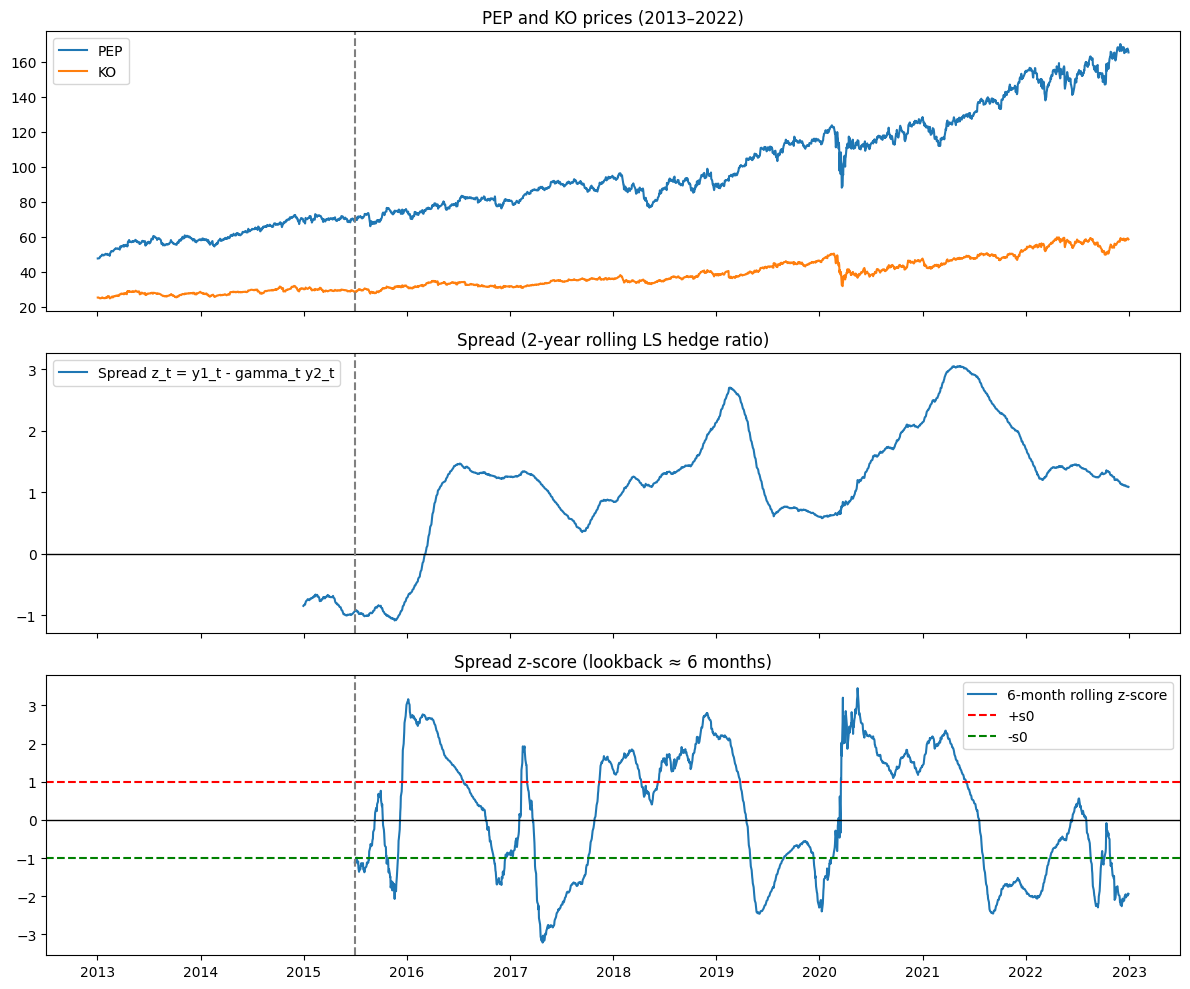

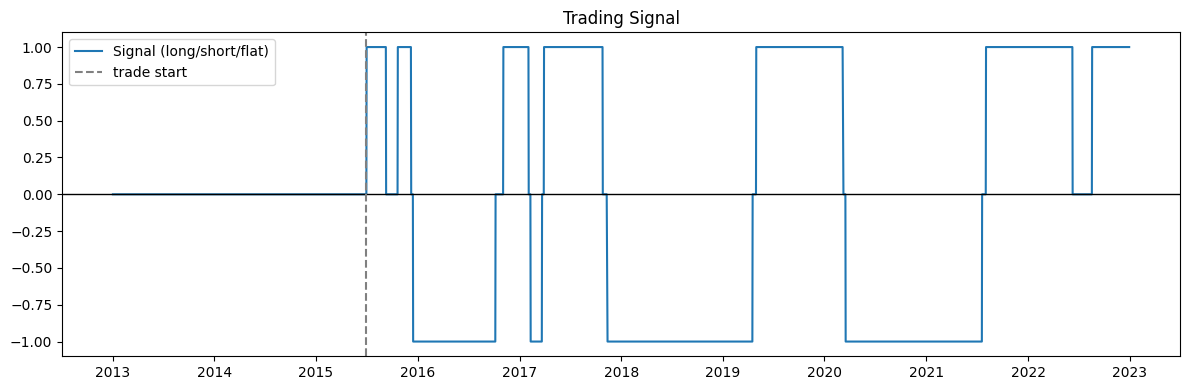

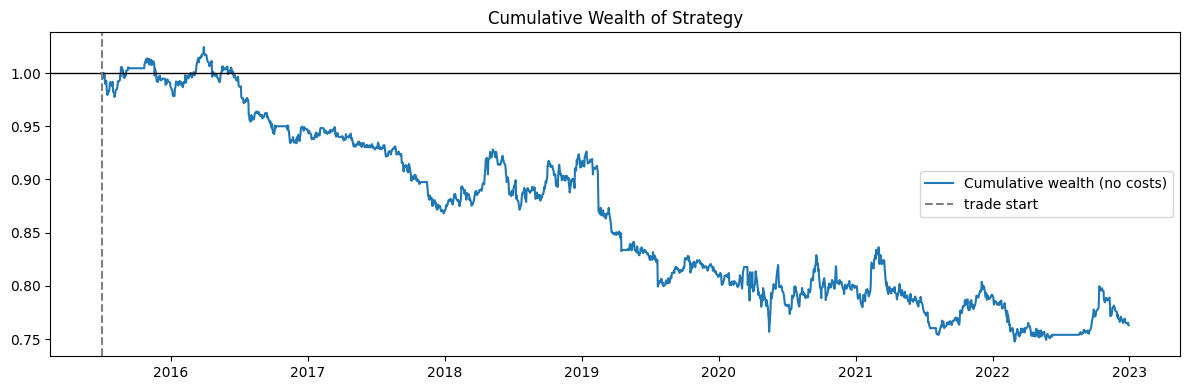

In [10]:


import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# -----------------------------
# 0. Parameters (Palomar-style)
# -----------------------------
ticker1 = "PEP"   # y1_t
ticker2 = "KO"    # y2_t

start_all = "2013-01-01"
end_all   = "2023-01-01"   # end is exclusive in yfinance, so covers 2013–2022

# rolling windows (approximate trading days)
T_trn   = 2 * 252   # ~2 years for hedge-ratio rolling LS
window_z = 126      # ~6 months for z-score

s0 = 1.0  # trading threshold

# -----------------------------
# 1. Download & prepare data
# -----------------------------
data = yf.download([ticker1, ticker2], start=start_all, end=end_all)["Close"]
data = data.dropna()

# log-prices (as in Palomar’s R code: log(Ad(getSymbols(...))))
y1 = np.log(data[ticker1])   # log PEP
y2 = np.log(data[ticker2])   # log KO

df = pd.DataFrame({"y1": y1, "y2": y2})

# -----------------------------
# 2. Engle–Granger cointegration test (KO–PEP)
#    H0: no cointegration
# -----------------------------
coint_t, p_value, crit_values = coint(df["y1"], df["y2"])
print("Engle–Granger cointegration test (log PEP vs log KO)")
print(f"  test statistic: {coint_t:.4f}")
print(f"  p-value:        {p_value:.4f}")
print("  critical values:", crit_values)

if p_value < 0.05:
    print("  -> Reject H0 at 5%: series appear COINTEGRATED.")
else:
    print("  -> Fail to reject H0 at 5%: NO strong evidence of cointegration "
          "(this matches Palomar's remark for KO–PEP).")

# -----------------------------
# 3. Rolling 2-year LS hedge ratio gamma_t
#    For each t, regress y1 on y2 over the last T_trn samples.
# -----------------------------
gamma_roll = pd.Series(index=df.index, dtype=float)

y1_arr = df["y1"].values
y2_arr = df["y2"].values
dates  = df.index

for t in range(len(df)):
    end_idx = t
    start_idx = end_idx - T_trn + 1
    if start_idx < 0:
        continue  # not enough data yet
    y1_win = y1_arr[start_idx:end_idx + 1]
    y2_win = y2_arr[start_idx:end_idx + 1]

    X_win = sm.add_constant(y2_win)
    res = sm.OLS(y1_win, X_win).fit()
    gamma_roll.iloc[t] = res.params[1]   # coefficient of y2

df["gamma_roll"] = gamma_roll

# -----------------------------
# 4. Spread and rolling z-score
#    Spread: z_t = y1_t - gamma_t * y2_t
# -----------------------------
spread = df["y1"] - df["gamma_roll"] * df["y2"]
df["spread"] = spread

# 6-month rolling z-score
spread_mean = spread.rolling(window_z).mean()
spread_std  = spread.rolling(window_z).std()
zscore      = (spread - spread_mean) / spread_std
df["zscore"] = zscore

# -----------------------------
# 5. Thresholded trading strategy (Palomar style)
#    s_t:
#      +1 = long spread  (long PEP, short gamma_t * KO)
#      -1 = short spread (short PEP, long gamma_t * KO)
#       0 = flat
# -----------------------------
def threshold_signals(zscore, s0=1.0, trade_start=None):
    """
    Palomar-style thresholded strategy on z-score:
      - enter long when z < -s0
      - enter short when z > +s0
      - exit when position sign opposes z's sign (i.e. reversion through 0)
    """
    s = pd.Series(0.0, index=zscore.index)

    # trading starts after we have good estimates
    if trade_start is not None:
        # ensure trade_start is in index
        if trade_start not in zscore.index:
            # pick the first date after the given trade_start
            trade_start = zscore.index[zscore.index.get_loc(trade_start, method="bfill")]
        start_idx = zscore.index.get_loc(trade_start)
    else:
        # first non-NaN zscore index
        start_idx = np.argmax(~np.isnan(zscore.values))

    for i in range(start_idx + 1, len(zscore)):
        z = zscore.iloc[i]
        if np.isnan(z):
            s.iloc[i] = s.iloc[i-1]
            continue

        prev_pos = s.iloc[i-1]

        if prev_pos == 0:
            # flat: open new position if z out of band
            if z > s0:
                s.iloc[i] = -1.0     # short spread
            elif z < -s0:
                s.iloc[i] = +1.0     # long spread
            else:
                s.iloc[i] = 0.0
        elif prev_pos > 0:   # currently long spread
            if z >= 0:
                s.iloc[i] = 0.0      # revert through 0 -> close
            else:
                s.iloc[i] = +1.0     # maintain
        else:                # currently short spread
            if z <= 0:
                s.iloc[i] = 0.0
            else:
                s.iloc[i] = -1.0

    # zero out positions before trade_start
    if trade_start is not None:
        s.loc[s.index < trade_start] = 0.0

    return s

# Choose trade start: after we have:
# - at least 2 years for hedge ratio
# - plus 6 months for z-score
first_gamma_idx = df.index[df["gamma_roll"].notna()][0]
first_z_idx     = df.index[df["zscore"].notna()][0]
trade_start_date = max(first_gamma_idx, first_z_idx)

df["signal"] = threshold_signals(df["zscore"], s0=s0, trade_start=trade_start_date)

# -----------------------------
# 6. Compute strategy returns (price-based)
#    Portfolio: w1_t * PEP + w2_t * KO, with
#       w1_t =  1 / (1 + gamma_t),
#       w2_t = -gamma_t / (1 + gamma_t)
#    Strategy return: signal_{t-1} * (w1_{t-1} * r1_t + w2_{t-1} * r2_t)
# -----------------------------
# Daily asset returns
ret1 = data[ticker1].pct_change().fillna(0.0)  # PEP
ret2 = data[ticker2].pct_change().fillna(0.0)  # KO

# Normalized hedge weights from rolling gamma
denom = 1.0 + df["gamma_roll"]
w1 = 1.0 / denom
w2 = -df["gamma_roll"] / denom

# Shift weights and signal: decide at t-1, apply at t
w1_shift = w1.shift(1).fillna(0.0)
w2_shift = w2.shift(1).fillna(0.0)
signal_shift = df["signal"].shift(1).fillna(0.0)

# Raw pair return (no on/off signal yet)
pair_ret = w1_shift * ret1 + w2_shift * ret2

# Strategy return with signal
strategy_ret = signal_shift * pair_ret

# Only evaluate PnL after trade_start_date
ret = strategy_ret.loc[trade_start_date:]
wealth = (1.0 + ret).cumprod()   # starting from 1

print(f"\nTrading start date: {trade_start_date.date()}")
print("Final wealth of KO–PEP pairs strategy (no costs): {:.3f}x".format(wealth.iloc[-1]))

# -----------------------------
# 7. Plots: prices, spread, z-score
# -----------------------------
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1) Prices
axes[0].plot(data.index, data[ticker1], label=ticker1)
axes[0].plot(data.index, data[ticker2], label=ticker2)
axes[0].set_title(f"{ticker1} and {ticker2} prices (2013–2022)")
axes[0].legend()
axes[0].axvline(trade_start_date, color="gray", linestyle="--", label="trade start")

# 2) Spread (still in log space, for diagnostics)
axes[1].plot(df.index, df["spread"], label="Spread z_t = y1_t - gamma_t y2_t")
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("Spread (2-year rolling LS hedge ratio)")
axes[1].legend()
axes[1].axvline(trade_start_date, color="gray", linestyle="--")

# 3) Z-score
axes[2].plot(df.index, df["zscore"], label="6-month rolling z-score")
axes[2].axhline(s0, color="red", linestyle="--", label="+s0")
axes[2].axhline(-s0, color="green", linestyle="--", label="-s0")
axes[2].axhline(0, color="black", linewidth=1)
axes[2].set_title("Spread z-score (lookback ≈ 6 months)")
axes[2].legend()
axes[2].axvline(trade_start_date, color="gray", linestyle="--")

plt.tight_layout()
plt.show()

# -----------------------------
# 8. Separate plot: Signal
# -----------------------------
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["signal"], label="Signal (long/short/flat)")
plt.axhline(0, color="black", linewidth=1)
plt.axvline(trade_start_date, color="gray", linestyle="--", label="trade start")
plt.title("Trading Signal")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 9. Separate plot: Cumulative wealth
# -----------------------------
plt.figure(figsize=(12, 4))
plt.plot(wealth.index, wealth, label="Cumulative wealth (no costs)")
plt.axhline(1.0, color="black", linewidth=1)
plt.axvline(trade_start_date, color="gray", linestyle="--", label="trade start")
plt.title("Cumulative Wealth of Strategy")
plt.legend()
plt.tight_layout()
plt.show()


# Simple Kalman Filter for Pair Trading (KO–PEP)

## 1. Model Setup

We consider two assets:

- $P_{1,t}$: price of Pepsi (PEP) at time $t$
- $P_{2,t}$: price of Coca-Cola (KO) at time $t$

We work with **log-prices**:

$$
y_{1,t} = \log P_{1,t}, \qquad
y_{2,t} = \log P_{2,t}.
$$

We assume that $y_{1,t}$ depends linearly on $y_{2,t}$ with **time-varying** intercept and slope (hedge ratio):

$$
y_{1,t} = \mu_t + \gamma_t\, y_{2,t} + \varepsilon_t,
$$

where

- $\mu_t$ is a time-varying intercept,
- $\gamma_t$ is a time-varying hedge ratio,
- $\varepsilon_t$ is observation noise.

This is the measurement equation of a **state-space model**.

---

## 2. State-Space Formulation

We define the **state vector**:

$$
\alpha_t =
\begin{bmatrix}
\mu_t \\
\gamma_t
\end{bmatrix}.
$$

### 2.1 Observation (measurement) equation

In matrix form,

$$
y_{1,t} = Z_t \alpha_t + \varepsilon_t,
$$

with

$$
Z_t = \begin{bmatrix} 1 & y_{2,t} \end{bmatrix},
\qquad
\varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2).
$$

So at each time $t$, we observe $y_{1,t}$ and $y_{2,t}$, and the observation depends linearly on the hidden state $\alpha_t$.

### 2.2 State (transition) equation

We assume that $(\mu_t, \gamma_t)$ follow a **random walk**:

$$
\alpha_{t+1} = \alpha_t + \eta_t,
\qquad
\eta_t \sim \mathcal{N}(0, Q),
$$

with

$$
Q =
\begin{bmatrix}
\sigma_\mu^2 & 0 \\
0 & \sigma_\gamma^2
\end{bmatrix}.
$$

This means that $\mu_t$ and $\gamma_t$ evolve slowly over time, driven by Gaussian noise.

---

## 3. Role of $\alpha$ (Hyperparameter)

We estimate $\sigma_\varepsilon^2$ and some basic scale information from an initial **static** regression on a training window (e.g. first 2 years):

$$
y_{1,t} = \mu^{(LS)} + \gamma^{(LS)} y_{2,t} + \varepsilon_t^{(LS)}.
$$

Let

- $\widehat{\sigma_\varepsilon^2} = \mathrm{Var}(\varepsilon_t^{(LS)})$,
- $\widehat{\sigma_{y_2}^2} = \mathrm{Var}(y_{2,t})$ on the same window.

We then choose the **process noise variances** using a small hyperparameter $\alpha$:

$$
\sigma_\mu^2 = \alpha \, \widehat{\sigma_\varepsilon^2},
\qquad
\sigma_\gamma^2 = \alpha \, \frac{\widehat{\sigma_\varepsilon^2}}{\widehat{\sigma_{y_2}^2}}.
$$

Here:

- $\alpha$ is a small positive number (e.g. $\alpha = 10^{-5}$).
- Larger $\alpha$ means **more flexible** $\mu_t$ and $\gamma_t$ (they can change faster).
- Smaller $\alpha$ means **smoother** $\mu_t$ and $\gamma_t$ (they change slowly).

So $\alpha$ controls the **trade-off between tracking changes and smoothing noise** in the hedge ratio.

---

## 4. Kalman Filter Recursion

Let

- $a_{t|t-1}$ and $P_{t|t-1}$ be the **predicted** state mean and covariance,
- $a_{t|t}$ and $P_{t|t}$ be the **updated** (filtered) state mean and covariance.

We initialize with

$$
a_{0|0} =
\begin{bmatrix}
\mu^{(LS)} \\
\gamma^{(LS)}
\end{bmatrix},
\qquad
P_{0|0} =
\begin{bmatrix}
\mathrm{Var}(\mu_0) & 0 \\
0 & \mathrm{Var}(\gamma_0)
\end{bmatrix},
$$

where the initial variances can be set proportional to $\widehat{\sigma_\varepsilon^2}$ (Palomar’s heuristic).

Then, for each time $t$:

### 4.1 Prediction (time update)

Since the state equation is $\alpha_{t+1} = \alpha_t + \eta_t$,

$$
a_{t|t-1} = a_{t-1|t-1},
$$

$$
P_{t|t-1} = P_{t-1|t-1} + Q.
$$

### 4.2 Update (measurement update)

Given observation $y_{1,t}$ and regressor $y_{2,t}$, define

$$
Z_t = \begin{bmatrix} 1 & y_{2,t} \end{bmatrix}.
$$

The **innovation** (prediction error) is

$$
\nu_t = y_{1,t} - Z_t a_{t|t-1}.
$$

The **innovation variance** is

$$
S_t = Z_t P_{t|t-1} Z_t^\top + \sigma_\varepsilon^2.
$$

The **Kalman gain** is

$$
K_t = P_{t|t-1} Z_t^\top S_t^{-1}.
$$

Then we update the state:

$$
a_{t|t} = a_{t|t-1} + K_t \nu_t,
$$

$$
P_{t|t} = (I - K_t Z_t) P_{t|t-1}.
$$

For pair trading, we often use the **predicted state** $(\mu_{t|t-1}, \gamma_{t|t-1})$ to construct the spread at time $t$.

---

## 5. Kalman-Based Spread and Trading Signal

From the predicted state $a_{t|t-1} = (\mu_{t|t-1}, \gamma_{t|t-1})^\top$, define the **normalized spread**:

$$
z_t = \frac{y_{1,t} - \mu_{t|t-1} - \gamma_{t|t-1} y_{2,t}}{1 + \gamma_{t|t-1}}.
$$

This corresponds to a portfolio with weights:

$$
w_{1,t} = \frac{1}{1 + \gamma_{t|t-1}}, \qquad
w_{2,t} = - \frac{\gamma_{t|t-1}}{1 + \gamma_{t|t-1}}.
$$

We then compute a **rolling z-score** of $z_t$ over a window of about 6 months (e.g. 126 trading days):

$$
m_t = \text{rolling mean of } z_t, \qquad
\sigma_t = \text{rolling std of } z_t,
$$

$$
\text{zscore}_t = \frac{z_t - m_t}{\sigma_t}.
$$

A simple thresholded strategy:

- If $\text{zscore}_t > s_0$: **short spread**
- If $\text{zscore}_t < -s_0$: **long spread**
- Exit when $\text{zscore}_t$ returns to 0

with $s_0 = 1$ as in the Palomar setup.

Approximate **log-return** of the spread portfolio is

$$
R_t = s_{t-1} (z_t - z_{t-1}),
$$

and the cumulative wealth is

$$
W_t = \exp\Big(\sum_{k \le t} R_k\Big).
$$


Training sample: 2013-01-02 to 2014-12-31
Full sample:     2013-01-02 to 2022-12-30

Initial LS regression on 2013–2014 (log PEP = mu + gamma * log KO):
                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     1902.
Date:                Fri, 21 Nov 2025   Prob (F-statistic):          7.12e-173
Time:                        17:16:55   Log-Likelihood:                 881.71
No. Observations:                 504   AIC:                            -1759.
Df Residuals:                     502   BIC:                            -1751.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

/tmp/ipython-input-1318184610.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat = float(Z @ a_pred)
/tmp/ipython-input-1318184610.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(Z @ Pp @ Z.T) + R



Trade start date: 2013-07-02
Final wealth of simple Kalman KO–PEP strategy (no costs): 1.138x


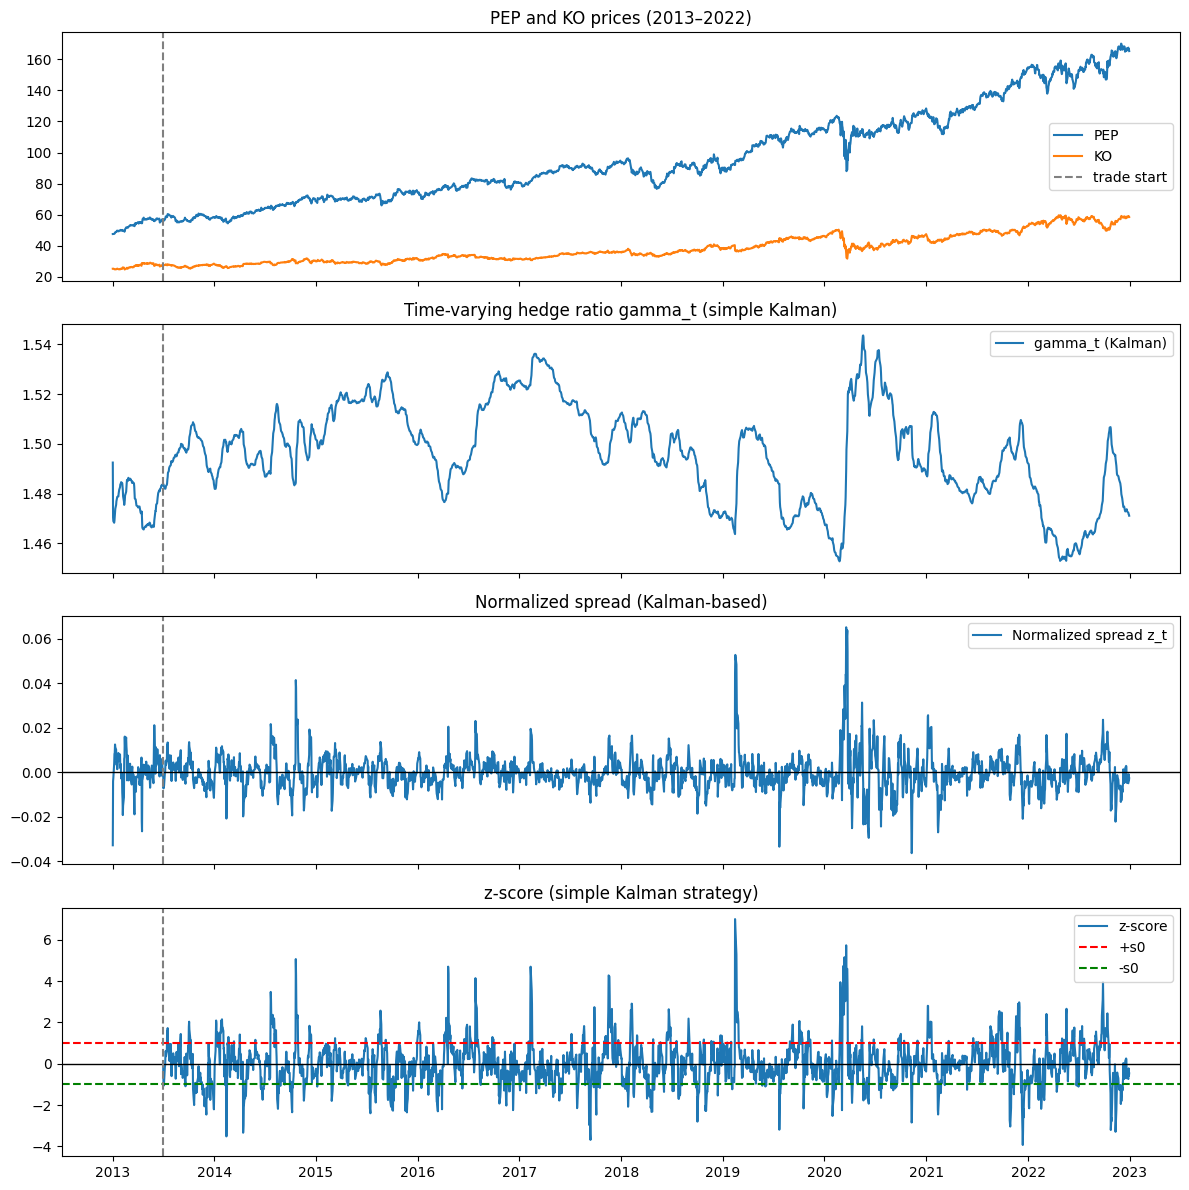

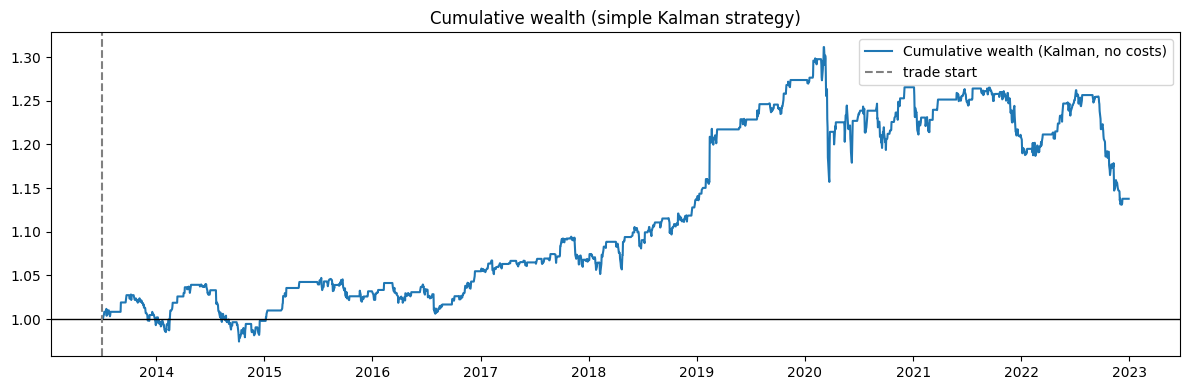

In [11]:

alpha_basic = 1e-5         # Kalman hyperparameter alpha
window_z = 126             # ~ 6 months of trading days for z-score
s0 = 1.0                   # z-score threshold


# Log-prices
y1 = np.log(data[ticker1])   # log PEP
y2 = np.log(data[ticker2])   # log KO

df = pd.DataFrame({"y1": y1, "y2": y2})

start_all = "2013-01-01"
end_all   = "2023-01-01"   # end is exclusive in yfinance

train_end = "2014-12-31"   # first two calendar years for LS

# Training mask for initial LS calibration (first two calendar years)
train_mask = df.index <= train_end
train = df.loc[train_mask]
test  = df.loc[~train_mask]   # out-of-sample period (for interpretation)

print(f"Training sample: {train.index[0].date()} to {train.index[-1].date()}")
print(f"Full sample:     {df.index[0].date()} to {df.index[-1].date()}")

# -----------------------------
# 2. Initial LS calibration
#    y1_t ≈ mu + gamma * y2_t
# -----------------------------
X_train = sm.add_constant(train["y2"])
ols_init = sm.OLS(train["y1"], X_train).fit()
mu_LS    = ols_init.params["const"]
gamma_LS = ols_init.params["y2"]

eps_train = train["y1"] - mu_LS - gamma_LS * train["y2"]
sigma_eps2 = np.var(eps_train, ddof=1)
sigma_y2_2 = np.var(train["y2"], ddof=1)
T_LS = len(train)

print("\nInitial LS regression on 2013–2014 (log PEP = mu + gamma * log KO):")
print(ols_init.summary())
print(f"\nmu_LS    ≈ {mu_LS:.6f}")
print(f"gamma_LS ≈ {gamma_LS:.6f}")
print(f"var_eps  ≈ {sigma_eps2:.6e}")
print(f"var_y2   ≈ {sigma_y2_2:.6e}")

# Initial state covariance (uncertainty about mu,gamma)
var_mu1    = (1.0 / T_LS) * sigma_eps2
var_gamma1 = (1.0 / T_LS) * sigma_eps2 / sigma_y2_2
P0 = np.diag([var_mu1, var_gamma1])

# Process noise variances (controlled by alpha)
sigma_mu2    = alpha_basic * sigma_eps2
sigma_gamma2 = alpha_basic * sigma_eps2 / sigma_y2_2
Q = np.diag([sigma_mu2, sigma_gamma2])

# Observation noise variance
R = sigma_eps2  # sigma_eps^2

print("\nKalman hyperparameters:")
print(f"alpha_basic   = {alpha_basic}")
print(f"sigma_mu^2    = {sigma_mu2:.6e}")
print(f"sigma_gamma^2 = {sigma_gamma2:.6e}")

# -----------------------------
# 3. Simple Kalman filter (2D state: [mu_t, gamma_t])
# -----------------------------
def kalman_basic(y1_arr, y2_arr, mu0, gamma0, P0, R, Q):
    """
    2D Kalman filter.

    State:       alpha_t = [mu_t, gamma_t]^T
                 alpha_{t+1} = alpha_t + eta_t,    eta_t ~ N(0, Q)
    Observation: y1_t     = [1, y2_t] alpha_t + eps_t, eps_t ~ N(0, R)

    Returns:
        mu_pred, gamma_pred: one-step-ahead predicted states (t|t-1)
        mu_filt, gamma_filt: filtered states (t|t)
    """
    n = len(y1_arr)
    mu_pred    = np.zeros(n)
    gamma_pred = np.zeros(n)
    mu_filt    = np.zeros(n)
    gamma_filt = np.zeros(n)

    P_pred = np.zeros((n, 2, 2))
    P_filt = np.zeros((n, 2, 2))

    # State transition is identity for random walk
    F = np.eye(2)

    # Initial state
    a_prev = np.array([mu0, gamma0], dtype=float)
    P_prev = P0.copy()

    for t in range(n):
        y1_t = y1_arr[t]
        y2_t = y2_arr[t]

        # Prediction step
        a_pred = F @ a_prev
        Pp = F @ P_prev @ F.T + Q

        mu_pred[t]    = a_pred[0]
        gamma_pred[t] = a_pred[1]
        P_pred[t] = Pp

        # Observation matrix Z_t = [1, y2_t]
        Z = np.array([[1.0, y2_t]])  # (1x2)

        # Innovation
        y_hat = float(Z @ a_pred)
        nu = y1_t - y_hat

        # Innovation variance
        S = float(Z @ Pp @ Z.T) + R

        # Kalman gain
        K = (Pp @ Z.T) / S  # (2x1)

        # Update
        a_filt = a_pred + (K.flatten() * nu)
        Pf = (np.eye(2) - K @ Z) @ Pp

        mu_filt[t]    = a_filt[0]
        gamma_filt[t] = a_filt[1]
        P_filt[t]     = Pf

        a_prev = a_filt
        P_prev = Pf

    return mu_pred, gamma_pred, mu_filt, gamma_filt, P_pred, P_filt

# Run Kalman filter on full data (2013–2022)
y1_arr = df["y1"].values
y2_arr = df["y2"].values
dates  = df.index

mu_pred, gamma_pred, mu_filt, gamma_filt, _, _ = kalman_basic(
    y1_arr, y2_arr,
    mu_LS, gamma_LS,
    P0, R, Q
)

df["mu_pred"]    = mu_pred
df["gamma_pred"] = gamma_pred

# -----------------------------
# 4. Normalized spread and z-score
#    z_t = (y1_t - mu_{t|t-1} - gamma_{t|t-1} y2_t) / (1 + gamma_{t|t-1})
# -----------------------------
denom = 1.0 + df["gamma_pred"]
# Avoid dividing by (almost) zero
denom_safe = denom.mask(denom.abs() < 1e-8, np.nan)

df["spread_norm"] = (df["y1"] - df["mu_pred"] - df["gamma_pred"] * df["y2"]) / denom_safe

# Rolling z-score over ~6 months
spread_mean = df["spread_norm"].rolling(window_z).mean()
spread_std  = df["spread_norm"].rolling(window_z).std()
df["zscore"] = (df["spread_norm"] - spread_mean) / spread_std


# Decide trade start date: after we have enough data for zscore
first_z_idx = df.index[df["zscore"].notna()][0]
trade_start_date = first_z_idx  # could also max(first_z_idx, some min date)

df["signal"] = threshold_signals(df["zscore"], s0=s0, trade_start=trade_start_date)

# -----------------------------
# 6. Strategy returns (price-based)
#    Portfolio weights from Kalman gamma_t:
#       w1_t =  1 / (1 + gamma_t)
#       w2_t = -gamma_t / (1 + gamma_t)
#    Daily return: signal_{t-1} * (w1_{t-1} * r1_t + w2_{t-1} * r2_t)
# -----------------------------
# Daily returns of the two assets
ret1 = data[ticker1].pct_change().fillna(0.0)  # PEP
ret2 = data[ticker2].pct_change().fillna(0.0)  # KO

# Normalized hedge weights from Kalman gamma_pred
denom_k = 1.0 + df["gamma_pred"]
w1_k = 1.0 / denom_k
w2_k = -df["gamma_pred"] / denom_k

# Shift weights and signal: decide at t-1, apply at t
w1_k_shift = w1_k.shift(1).fillna(0.0)
w2_k_shift = w2_k.shift(1).fillna(0.0)
signal_k_shift = df["signal"].shift(1).fillna(0.0)

# Raw pair return (no on/off yet)
pair_ret_kalman = w1_k_shift * ret1 + w2_k_shift * ret2

# Strategy return with signal
strategy_ret_kalman = signal_k_shift * pair_ret_kalman

# Only evaluate returns after trade_start_date
ret_kalman = strategy_ret_kalman.loc[trade_start_date:]
wealth_kalman = (1.0 + ret_kalman).cumprod()

print(f"\nTrade start date: {trade_start_date.date()}")
print("Final wealth of simple Kalman KO–PEP strategy (no costs): {:.3f}x".format(
    wealth_kalman.iloc[-1]
))

# -----------------------------
# 7. Plots – prices, gamma, spread, z-score
# -----------------------------
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# (1) Prices
axes[0].plot(data.index, data[ticker1], label=ticker1)
axes[0].plot(data.index, data[ticker2], label=ticker2)
axes[0].axvline(trade_start_date, color="gray", linestyle="--", label="trade start")
axes[0].set_title(f"{ticker1} and {ticker2} prices (2013–2022)")
axes[0].legend()

# (2) Kalman-estimated gamma_t
axes[1].plot(df.index, df["gamma_pred"], label="gamma_t (Kalman)")
axes[1].axvline(trade_start_date, color="gray", linestyle="--")
axes[1].set_title("Time-varying hedge ratio gamma_t (simple Kalman)")
axes[1].legend()

# (3) Normalized spread (for diagnostics)
axes[2].plot(df.index, df["spread_norm"], label="Normalized spread z_t")
axes[2].axhline(0, color="black", linewidth=1)
axes[2].axvline(trade_start_date, color="gray", linestyle="--")
axes[2].set_title("Normalized spread (Kalman-based)")
axes[2].legend()

# (4) z-score only
axes[3].plot(df.index, df["zscore"], label="z-score")
axes[3].axhline(s0, color="red", linestyle="--", label="+s0")
axes[3].axhline(-s0, color="green", linestyle="--", label="-s0")
axes[3].axhline(0, color="black", linewidth=1)
axes[3].axvline(trade_start_date, color="gray", linestyle="--")
axes[3].set_title("z-score (simple Kalman strategy)")
axes[3].legend()

plt.tight_layout()
plt.show()

# -----------------------------
# 8. Separate plot – cumulative wealth
# -----------------------------
plt.figure(figsize=(12, 4))
plt.plot(wealth_kalman.index, wealth_kalman, label="Cumulative wealth (Kalman, no costs)")
plt.axhline(1.0, color="black", linewidth=1)
plt.axvline(trade_start_date, color="gray", linestyle="--", label="trade start")
plt.title("Cumulative wealth (simple Kalman strategy)")
plt.legend()
plt.tight_layout()
plt.show()




# Momentum Kalman Filter for Pair Trading (KO–PEP)

## 1. Motivation

In the **simple Kalman** model, the hedge ratio $\gamma_t$ is modeled as a random walk:

$$
\gamma_{t+1} = \gamma_t + \eta_{\gamma,t}.
$$

This allows $\gamma_t$ to move slowly, but it does **not** explicitly model its *trend* or *velocity*.  
The **momentum Kalman** model refines this by introducing a *velocity* term for $\gamma_t$.

Idea:

- $\gamma_t$ itself should evolve smoothly.
- Its *rate of change* (a kind of “momentum”) is another state variable.

---

## 2. State-Space Model with Momentum

We again work with log-prices:

$$
y_{1,t} = \log P_{1,t}, \qquad
y_{2,t} = \log P_{2,t},
$$

where $P_{1,t}$ is Pepsi (PEP) and $P_{2,t}$ is Coca-Cola (KO).

We model:

$$
y_{1,t} = \mu_t + \gamma_t y_{2,t} + \varepsilon_t,
\qquad
\varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2).
$$

The **state vector** now includes a *velocity* for $\gamma_t$:

$$
\alpha_t =
\begin{bmatrix}
\mu_t \\
\gamma_t \\
\dot{\gamma}_t
\end{bmatrix}.
$$

### 2.1 Observation equation

In matrix form:

$$
y_{1,t} = Z_t \alpha_t + \varepsilon_t,
$$

with

$$
Z_t = \begin{bmatrix} 1 & y_{2,t} & 0 \end{bmatrix}.
$$

Only $\mu_t$ and $\gamma_t$ enter the observation; $\dot{\gamma}_t$ affects future $\gamma$ through the state equation.

### 2.2 State (transition) equation with momentum

We use a simple “constant-velocity” structure:

$$
\begin{bmatrix}
\mu_{t+1} \\
\gamma_{t+1} \\
\dot{\gamma}_{t+1}
\end{bmatrix}
=
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 1 \\
0 & 0 & 1
\end{bmatrix}
}_{F}
\begin{bmatrix}
\mu_t \\
\gamma_t \\
\dot{\gamma}_t
\end{bmatrix}
+
\eta_t,
$$

where

$$
\eta_t \sim \mathcal{N}(0, Q),
$$

and typically

$$
Q =
\begin{bmatrix}
\sigma_\mu^2 & 0 & 0 \\
0 & \sigma_\gamma^2 & 0 \\
0 & 0 & \sigma_{\dot{\gamma}}^2
\end{bmatrix}.
$$

Interpretation:

- $\mu_{t+1} = \mu_t + \text{noise}$ (random walk intercept).
- $\gamma_{t+1} = \gamma_t + \dot{\gamma}_t + \text{noise}$ (integrates the velocity).
- $\dot{\gamma}_{t+1} = \dot{\gamma}_t + \text{noise}$ (velocity itself follows a random walk).

This lets $\gamma_t$ change *smoothly* with some persistence in its trend.

---

## 3. Role of $\alpha$ in the Momentum Model

As with the simple Kalman model, we estimate basic scales from an initial static regression on a training window (e.g. 2013–2014):

$$
y_{1,t} = \mu^{(LS)} + \gamma^{(LS)} y_{2,t} + \varepsilon_t^{(LS)}.
$$

From this we get:

- Residual variance:
  $$
  \widehat{\sigma_\varepsilon^2} = \mathrm{Var}(\varepsilon_t^{(LS)}),
  $$
- Variance of $y_{2,t}$:
  $$
  \widehat{\sigma_{y_2}^2} = \mathrm{Var}(y_{2,t}).
  $$

Then we choose process noise variances via a **small hyperparameter** $\alpha$:

$$
\sigma_\mu^2 = \alpha \, \widehat{\sigma_\varepsilon^2},
\qquad
\sigma_\gamma^2 = \alpha \, \frac{\widehat{\sigma_\varepsilon^2}}{\widehat{\sigma_{y_2}^2}},
\qquad
\sigma_{\dot{\gamma}}^2 \approx \sigma_\gamma^2.
$$

Here:

- $\alpha$ (for momentum Kalman often even smaller, e.g. $\alpha = 10^{-6}$) controls how “wiggly” the state is:
  - Larger $\alpha$: $\mu_t, \gamma_t, \dot{\gamma}_t$ adapt **quickly** but can be noisy.
  - Smaller $\alpha$: they change **slowly**, giving smoother hedge ratios.

So $\alpha$ again tunes the **smoothness vs reactivity** of the time-varying hedge ratio, now with an extra degree of freedom via $\dot{\gamma}_t$.

---

## 4. Momentum Kalman Filter Recursion

Let

- $a_{t|t-1}$, $P_{t|t-1}$ be the predicted state mean and covariance.
- $a_{t|t}$, $P_{t|t}$ be the updated (filtered) state mean and covariance.

Initialize with:

$$
a_{0|0} =
\begin{bmatrix}
\mu^{(LS)} \\
\gamma^{(LS)} \\
0
\end{bmatrix},
$$

and a diagonal $P_{0|0}$ based on the LS variances (e.g. same variance for $\gamma_0$ and $\dot{\gamma}_0$).

Given the transition matrix $F$ and process covariance $Q$, the **prediction step** is:

$$
a_{t|t-1} = F a_{t-1|t-1},
$$

$$
P_{t|t-1} = F P_{t-1|t-1} F^\top + Q.
$$

Given observation $y_{1,t}$ and $y_{2,t}$, define:

$$
Z_t = \begin{bmatrix} 1 & y_{2,t} & 0 \end{bmatrix}.
$$

The **innovation** is:

$$
\nu_t = y_{1,t} - Z_t a_{t|t-1},
$$

with **innovation variance**:

$$
S_t = Z_t P_{t|t-1} Z_t^\top + \sigma_\varepsilon^2.
$$

The **Kalman gain**:

$$
K_t = P_{t|t-1} Z_t^\top S_t^{-1}.
$$

Update:

$$
a_{t|t} = a_{t|t-1} + K_t \nu_t,
$$

$$
P_{t|t} = (I - K_t Z_t)\, P_{t|t-1}.
$$

From $a_{t|t-1}$ we extract:

$$
\mu_{t|t-1}, \qquad \gamma_{t|t-1}, \qquad \dot{\gamma}_{t|t-1},
$$

and use $\mu_{t|t-1}$ and $\gamma_{t|t-1}$ for trading.

---

## 5. Momentum Kalman Spread and Trading Strategy

As in the simple Kalman case, we define a **normalized spread** based on the predicted state:

$$
z_t = \frac{y_{1,t} - \mu_{t|t-1} - \gamma_{t|t-1} y_{2,t}}{1 + \gamma_{t|t-1}}.
$$

Portfolio weights:

$$
w_{1,t} = \frac{1}{1 + \gamma_{t|t-1}}, \qquad
w_{2,t} = - \frac{\gamma_{t|t-1}}{1 + \gamma_{t|t-1}}.
$$

We compute a **rolling z-score** over about 6 months (e.g. 126 trading days):

$$
m_t = \text{rolling mean of } z_t, \qquad
\sigma_t = \text{rolling std of } z_t,
$$

$$
\text{zscore}_t = \frac{z_t - m_t}{\sigma_t}.
$$

Threshold strategy (Palomar-style, with $s_0 = 1$):

- If $\text{zscore}_t > s_0$: **short spread** (short PEP, long KO).
- If $\text{zscore}_t < -s_0$: **long spread** (long PEP, short KO).
- If in a position, **exit** when $\text{zscore}_t$ crosses 0.

Approximate log-return of the normalized spread portfolio:

$$
R_t = s_{t-1} (z_t - z_{t-1}),
$$

and cumulative wealth:

$$
W_t = \exp\Big(\sum_{k \le t} R_k \Big).
$$



Momentum Kalman hyperparameters:
alpha_mom    = 1e-06
sigma_mu^2   = 1.773591e-09
sigma_gamma^2= 5.878387e-07
sigma_gdot^2 = 5.878387e-07


/tmp/ipython-input-2785472605.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat = float(Z @ a_pred)
/tmp/ipython-input-2785472605.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(Z @ Pp @ Z.T) + R



Trade start date (momentum KF): 2013-07-02
Final wealth of momentum Kalman KO–PEP strategy (no costs): 1.011x


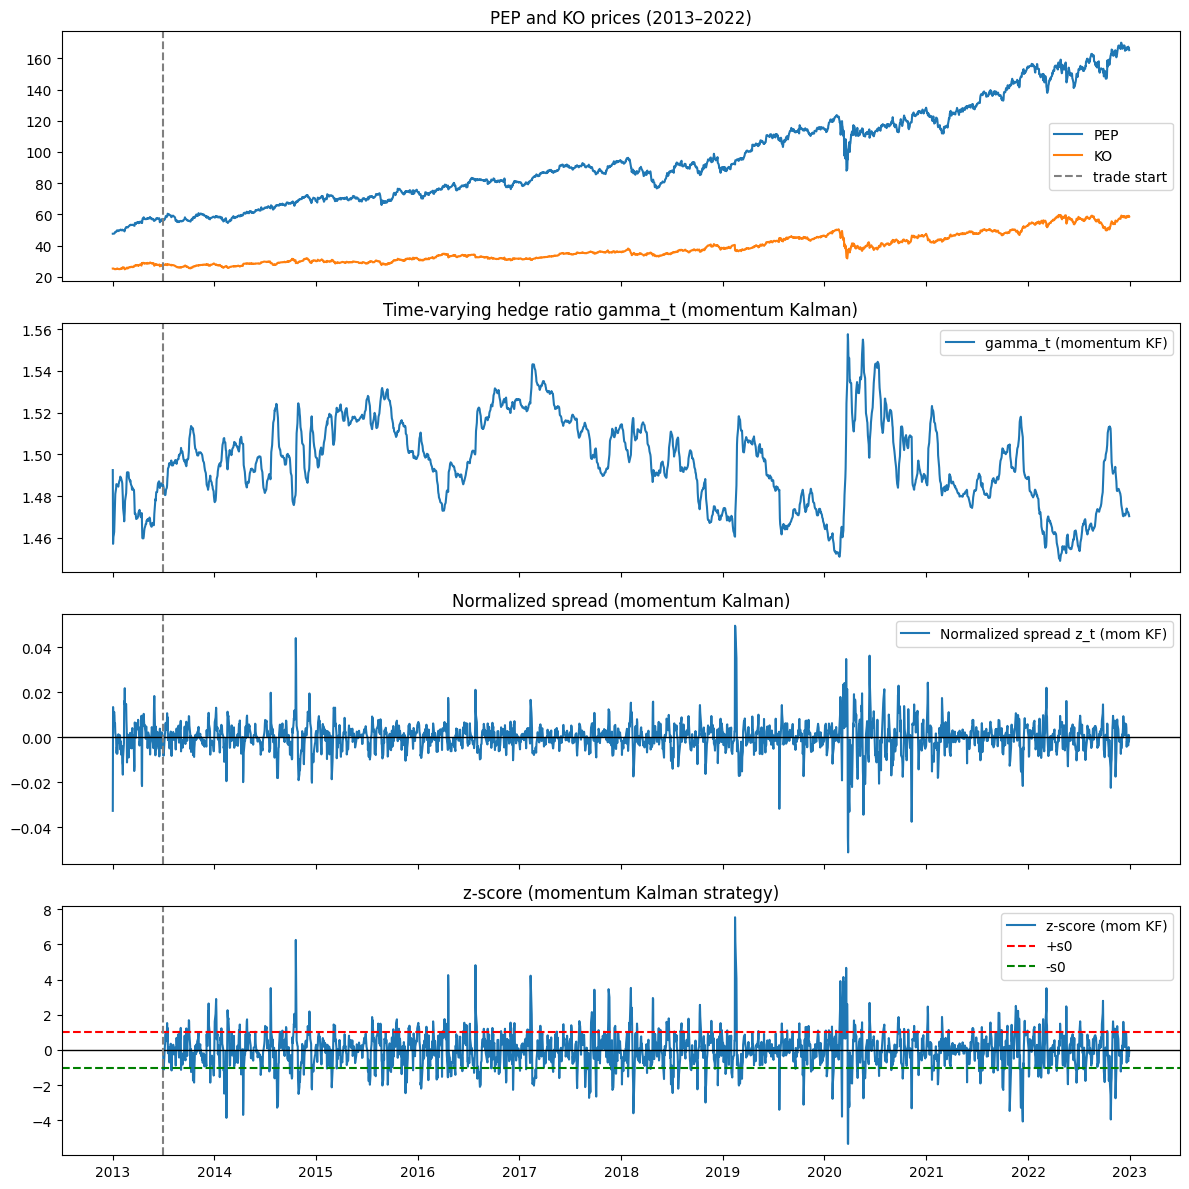

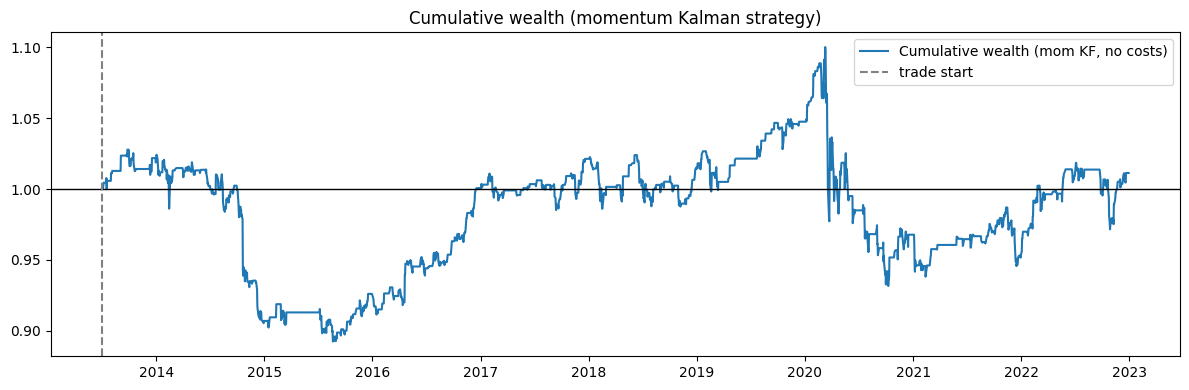

In [12]:


alpha_mom = 1e-6           # momentum Kalman hyperparameter
window_z  = 126            # ~ 6 months of trading days
s0        = 1.0            # z-score threshold



var_mu1    = (1.0 / T_LS) * sigma_eps2
var_gamma1 = (1.0 / T_LS) * sigma_eps2 / sigma_y2_2
P0 = np.diag([var_mu1, var_gamma1, var_gamma1])  # simple choice: same for gamma and gdot

# Process noise variances using alpha_mom
sigma_mu2    = alpha_mom * sigma_eps2
sigma_gamma2 = alpha_mom * sigma_eps2 / sigma_y2_2
sigma_gdot2  = sigma_gamma2  # simple choice
Q = np.diag([sigma_mu2, sigma_gamma2, sigma_gdot2])

# Observation noise variance
R = sigma_eps2

print("\nMomentum Kalman hyperparameters:")
print(f"alpha_mom    = {alpha_mom}")
print(f"sigma_mu^2   = {sigma_mu2:.6e}")
print(f"sigma_gamma^2= {sigma_gamma2:.6e}")
print(f"sigma_gdot^2 = {sigma_gdot2:.6e}")

# -----------------------------
# 3. Momentum Kalman filter implementation (3D state)
# -----------------------------
def kalman_momentum(y1_arr, y2_arr, mu0, gamma0, P0, R, Q):
    """
    3D momentum Kalman filter.

    State: alpha_t = [mu_t, gamma_t, gdot_t]^T
           transition:
             [mu_{t+1}]     [1 0 0][mu_t   ]   [eta_mu   ]
             [gamma_{t+1}] =[0 1 1][gamma_t] + [eta_gamma]
             [gdot_{t+1}]  [0 0 1][gdot_t ]   [eta_gdot ]

    Observation:
        y1_t = [1, y2_t, 0] alpha_t + eps_t, eps_t ~ N(0, R)
    """
    n = len(y1_arr)

    mu_pred    = np.zeros(n)
    gamma_pred = np.zeros(n)
    mu_filt    = np.zeros(n)
    gamma_filt = np.zeros(n)

    P_pred = np.zeros((n, 3, 3))
    P_filt = np.zeros((n, 3, 3))

    # Transition matrix F
    F = np.array([[1.0, 0.0, 0.0],
                  [0.0, 1.0, 1.0],
                  [0.0, 0.0, 1.0]])

    # Initial state
    a_prev = np.array([mu0, gamma0, 0.0], dtype=float)  # start with zero velocity
    P_prev = P0.copy()

    for t in range(n):
        y1_t = y1_arr[t]
        y2_t = y2_arr[t]

        # Prediction
        a_pred = F @ a_prev
        Pp = F @ P_prev @ F.T + Q

        mu_pred[t]    = a_pred[0]
        gamma_pred[t] = a_pred[1]
        P_pred[t]     = Pp

        # Observation matrix Z_t = [1, y2_t, 0]
        Z = np.array([[1.0, y2_t, 0.0]])   # shape (1,3)

        # Innovation
        y_hat = float(Z @ a_pred)
        nu = y1_t - y_hat

        # Innovation variance
        S = float(Z @ Pp @ Z.T) + R

        # Kalman gain
        K = (Pp @ Z.T) / S   # (3x1)

        # Update
        a_filt = a_pred + (K.flatten() * nu)
        Pf = (np.eye(3) - K @ Z) @ Pp

        mu_filt[t]    = a_filt[0]
        gamma_filt[t] = a_filt[1]
        P_filt[t]     = Pf

        a_prev = a_filt
        P_prev = Pf

    return mu_pred, gamma_pred, mu_filt, gamma_filt, P_pred, P_filt

# Run momentum Kalman on full sample
y1_arr = df["y1"].values
y2_arr = df["y2"].values
dates  = df.index

mu_pred, gamma_pred, mu_filt, gamma_filt, _, _ = kalman_momentum(
    y1_arr, y2_arr,
    mu_LS, gamma_LS,
    P0, R, Q
)

df["mu_pred_mom"]    = mu_pred
df["gamma_pred_mom"] = gamma_pred

# -----------------------------
# 4. Normalized spread and z-score
#    z_t = (y1_t - mu_{t|t-1} - gamma_{t|t-1} * y2_t) / (1 + gamma_{t|t-1})
# -----------------------------
denom = 1.0 + df["gamma_pred_mom"]
denom_safe = denom.mask(denom.abs() < 1e-8, np.nan)

df["spread_norm_mom"] = (df["y1"] - df["mu_pred_mom"] - df["gamma_pred_mom"] * df["y2"]) / denom_safe

spread_mean = df["spread_norm_mom"].rolling(window_z).mean()
spread_std  = df["spread_norm_mom"].rolling(window_z).std()
df["zscore_mom"] = (df["spread_norm_mom"] - spread_mean) / spread_std


# Trade start: after we have valid z-score
first_z_idx = df.index[df["zscore_mom"].notna()][0]
trade_start_date = first_z_idx

df["signal_mom"] = threshold_signals(df["zscore_mom"], s0=s0, trade_start=trade_start_date)

# -----------------------------
# 6. Strategy returns (price-based)
#    Portfolio weights from momentum Kalman gamma_t:
#       w1_t =  1 / (1 + gamma_t)
#       w2_t = -gamma_t / (1 + gamma_t)
#    Daily return: signal_{t-1} * (w1_{t-1} * r1_t + w2_{t-1} * r2_t)
# -----------------------------
# If you already computed ret1, ret2 earlier you can reuse them;
# otherwise compute again here:
ret1 = data[ticker1].pct_change().fillna(0.0)  # PEP
ret2 = data[ticker2].pct_change().fillna(0.0)  # KO

# Normalized hedge weights from momentum Kalman gamma_pred_mom
denom_m = 1.0 + df["gamma_pred_mom"]
w1_m = 1.0 / denom_m
w2_m = -df["gamma_pred_mom"] / denom_m

# Shift weights and signal: decide at t-1, apply at t
w1_m_shift = w1_m.shift(1).fillna(0.0)
w2_m_shift = w2_m.shift(1).fillna(0.0)
signal_m_shift = df["signal_mom"].shift(1).fillna(0.0)

# Raw pair return (no on/off yet)
pair_ret_mom = w1_m_shift * ret1 + w2_m_shift * ret2

# Strategy return with signal
strategy_ret_mom = signal_m_shift * pair_ret_mom

# Only evaluate returns after trade_start_date
ret_mom = strategy_ret_mom.loc[trade_start_date:]
wealth_mom = (1.0 + ret_mom).cumprod()

print(f"\nTrade start date (momentum KF): {trade_start_date.date()}")
print("Final wealth of momentum Kalman KO–PEP strategy (no costs): {:.3f}x".format(
    wealth_mom.iloc[-1]
))

# -----------------------------
# 7. Plots – prices, gamma, spread, z-score
# -----------------------------
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# (1) Prices
axes[0].plot(data.index, data[ticker1], label=ticker1)
axes[0].plot(data.index, data[ticker2], label=ticker2)
axes[0].axvline(trade_start_date, color="gray", linestyle="--", label="trade start")
axes[0].set_title(f"{ticker1} and {ticker2} prices (2013–2022)")
axes[0].legend()

# (2) Momentum Kalman gamma_t
axes[1].plot(df.index, df["gamma_pred_mom"], label="gamma_t (momentum KF)")
axes[1].axvline(trade_start_date, color="gray", linestyle="--")
axes[1].set_title("Time-varying hedge ratio gamma_t (momentum Kalman)")
axes[1].legend()

# (3) Normalized spread (diagnostic)
axes[2].plot(df.index, df["spread_norm_mom"], label="Normalized spread z_t (mom KF)")
axes[2].axhline(0, color="black", linewidth=1)
axes[2].axvline(trade_start_date, color="gray", linestyle="--")
axes[2].set_title("Normalized spread (momentum Kalman)")
axes[2].legend()

# (4) z-score only
axes[3].plot(df.index, df["zscore_mom"], label="z-score (mom KF)")
axes[3].axhline(s0, color="red", linestyle="--", label="+s0")
axes[3].axhline(-s0, color="green", linestyle="--", label="-s0")
axes[3].axhline(0, color="black", linewidth=1)
axes[3].axvline(trade_start_date, color="gray", linestyle="--")
axes[3].set_title("z-score (momentum Kalman strategy)")
axes[3].legend()

plt.tight_layout()
plt.show()

# -----------------------------
# 8. Separate plot – cumulative wealth
# -----------------------------
plt.figure(figsize=(12, 4))
plt.plot(wealth_mom.index, wealth_mom, label="Cumulative wealth (mom KF, no costs)")
plt.axhline(1.0, color="black", linewidth=1)
plt.axvline(trade_start_date, color="gray", linestyle="--", label="trade start")
plt.title("Cumulative wealth (momentum Kalman strategy)")
plt.legend()
plt.tight_layout()
plt.show()


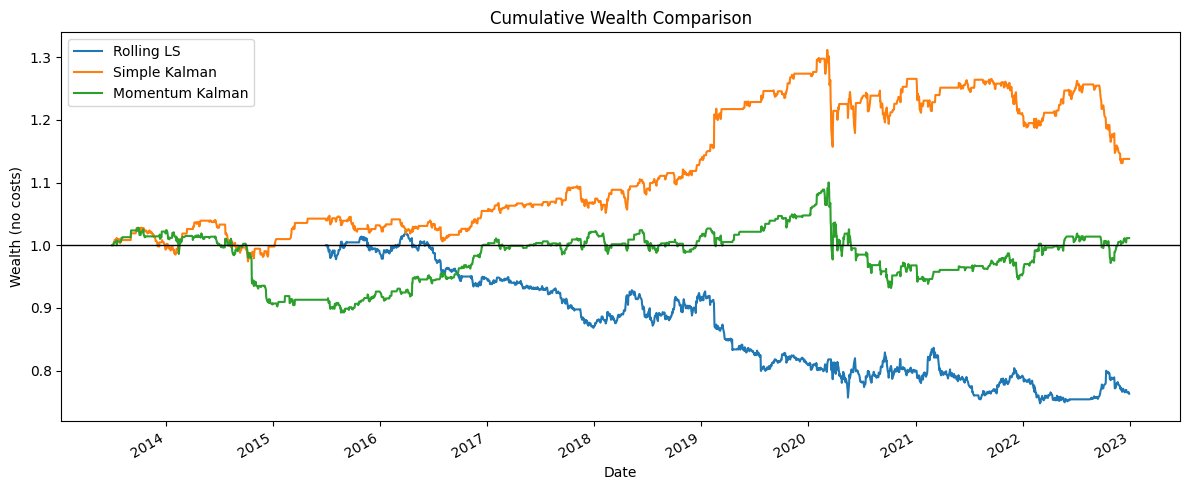

In [13]:
wealth_df = pd.concat(
    [wealth, wealth_kalman, wealth_mom],
    axis=1
)
wealth_df.columns = ["Rolling LS", "Simple Kalman", "Momentum Kalman"]

plt.figure(figsize=(12, 5))
wealth_df.plot(ax=plt.gca())
plt.axhline(1.0, color="black", linewidth=1)
plt.title("Cumulative Wealth Comparison")
plt.xlabel("Date")
plt.ylabel("Wealth (no costs)")
plt.tight_layout()
plt.show()
